In [43]:
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use(['seaborn'])
sns.set(font_scale=2.5)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].apply(lambda x: np.log(x) if x>0 else 0)
df_test['Fare'] = df_test['Fare'].apply(lambda x: np.log(x) if x>0 else 0)

In [44]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')  # extract the Salutations

df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')  # extract the Salutations

df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'], inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'], inplace=True)

df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial']=='Mr'),'Age'] = 33
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial']=='Master'),'Age'] = 5
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial']=='Miss'),'Age'] = 22
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial']=='Mrs'),'Age'] = 36
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial']=='Other'),'Age'] = 46

df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial']=='Mr'),'Age'] = 33
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial']=='Master'),'Age'] = 5
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial']=='Miss'),'Age'] = 22
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial']=='Mrs'),'Age'] = 36
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial']=='Other'),'Age'] = 46

df_train['Embarked'].fillna('S', inplace=True)

def cat_age(x):
    if x<10:
        return 0
    elif x<20:
        return 1
    elif x<30:
        return 2
    elif x<40:
        return 3
    elif x<50:
        return 4
    elif x<60:
        return 5
    elif x<70:
        return 6
    else:
        return 7
    
df_train['Age_cat'] = df_train['Age'].apply(cat_age)
df_test['Age_cat'] = df_test['Age'].apply(cat_age)

df_train.drop('Age', axis=1, inplace=True)
df_test.drop('Age', axis=1, inplace=True)

df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2,'Mrs':3,'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2,'Mrs':3,'Other':4})

df_train['Embarked'] = df_train['Embarked'].map({'C':0,'Q':1,'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0,'Q':1,'S':2})

df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

df_train.drop(['PassengerId', 'Name','SibSp','Parch','Ticket','Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name','SibSp','Parch','Ticket','Cabin'], axis=1, inplace=True)

In [45]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [46]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


## 4. Building machine learning model and prediction using the trained model

In [47]:
# importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier # radomforestclassifier
from sklearn import metrics # 모델의 평가
from sklearn.model_selection import train_test_split # training set을 쉽게 나눠주는 함수

- Sklearn 은 머신러닝의 처음부터 끝까지가 다 있다. feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있다. 데이터 분석 + 머신러닝을 하고싶다면, 이 라이브러리는 반드시 숙지해야한다.


- 타이타닉 문제는 target class(survived)가 있으며, target class 는 0, 1로 이루어져 있으므로(binary) binary classfication 문제이다.


- 우리가 지금 가지고 있는 train set 의 survived를 제외한 input 을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어 낸다.


- 그 후 모델이 학습하지 않았던 test set 을 input 으로 주어서 test set 의 각 샘플(탑승객)의 생존 유무를 예측해본다.

### 4.1 Preperation - Split the dataset into train, valid, test set

- 가장 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리한다. drop 을 사용해 간단히 할 수 있다.

In [48]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

- 보통 train, test 만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid set을 따로 만들어 모델 평가를 해본다.


- train_test_split 함수를 사용하여 쉽게 train set을 분리가능하다.

In [49]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state = 2018)

- sklearn 에서는 여러 머신러닝 알고리즘을 지원해준다. 열거하기엔 너무 많으므로, 직접 documentation에 들어가 보길 추천한다.  
http://scikit-learn.org/stable/supervised_learning.html#supervised-learning 


- 본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 한다.


- 랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델입니다.


- 각 머신러닝 알고리즘에는 여러 파라미터들이 있다. 랜덤포레스트분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재한다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라진다.


- 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요하다. 결국 많이 써봐야 모델도 잘 세울 수 있다.


- 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두기로 하고, 기본 default 세팅으로 진행하도록 한다.


- 모델 객체를 만들고, fit 메소드로 학습시킨다.


- 그런 후 valid set input 을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 얻는다.

### 4.2 Model generation and prediction

In [50]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [51]:
print('총 {0}명 중 {1:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100*metrics.accuracy_score(prediction, y_vld)))

총 268명 중 83.21% 정확도로 생존을 맞춤


In [52]:
pd.crosstab(prediction, y_vld, margins=True)

col_0,0,1,All
row_0,,,
0,154,27,181
1,18,69,87
All,172,96,268


### 4.3 Feature Importance

- 학습된 모델은 feature importance 를 가지게 되는데, 우리는 이것을 확인하여 우리가 **만든 모델**이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있다.



- 쉽게 말해, 10 = 4 * x_1 + 2 * x_2 + 1 * x_3 을 생각하면, 우리는 x1이 결과값(10)에 큰 영향을 준다고 생각 할 수 있다. feature importance 는 4, 2, 1 을 이야기하며, x1이 가장 큰 값(4)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있다.


- 학습된 모델은 기본적으로 featureimportances 를 가지고 있어서 쉽게 그 수치를 얻을 수 있다.


- pandas series 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있다.

In [53]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

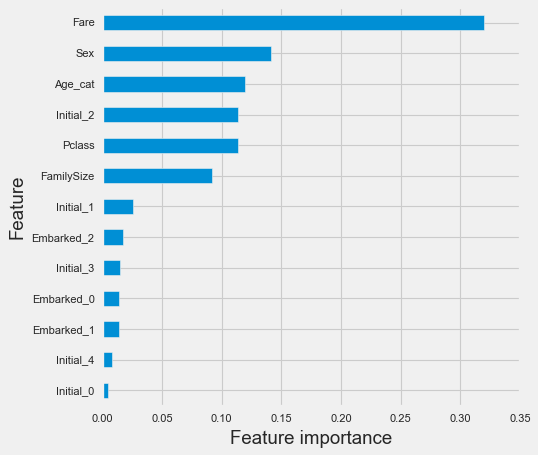

In [65]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6,6))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- 우리가 얻은 모델에서는 Fare 가 가장 큰 영향력을 가지며, 그 뒤로 Sex,  Age_cat, Initial_2, Pclass, FamilySize 가 차례로 중요도를 가진다.


- 사실 feature importance 는 **지금 모델에서의** importance 를 나타낸다. 만약 다른 모델을 사용하게 된다면 feature importance 가 다르게 나올 수 있다.


- 이 feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야한다.


- feature importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수 있다.

## 4.4 Prediction on Test set


- 이제 모델이 학습하지 않았던(보지 않았던) 테스트셋을 모델에 주어서, 생존여부를 예측해보도록 한다.


- 이 결과는 실제로 submission(제출용) 이므로 결과는 leaderboard 에서 확인할 수 있다.


- 캐글에서 준 파일, gender_submission.csv 파일을 읽어서 제출 준비를 한다.

In [68]:
submission = pd.read_csv('gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


- 이제 testset 에 대하여 예측을 하고, 결과를 csv 파일로 저장해본다.

In [69]:
prediction = model.predict(X_test)

In [72]:
submission['Survived'] = prediction

In [74]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [75]:
submission.to_csv('my_first_submission.csv', index=False) # Index를 False해주어야 위의 모양 그대로 저장된다.